## Exploratory Data Analysis

In [23]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm 
from concurrent.futures import ThreadPoolExecutor, as_completed


In [7]:
data = pd.read_csv("../Data/home_sdf_marketing_sample_for_flipkart_com-ecommerce__20191101_20191130__15k_data.csv" , on_bad_lines="skip")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14935 entries, 0 to 14934
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Uniq Id                14935 non-null  object
 1   Crawl Timestamp        14935 non-null  object
 2   Bb Category            14935 non-null  object
 3   Product Title          14935 non-null  object
 4   Product Description    2604 non-null   object
 5   Brand                  14935 non-null  object
 6   Quantity Or Pack Size  14835 non-null  object
 7   Mrp                    14935 non-null  object
 8   Price                  14935 non-null  object
 9   Site Name              14935 non-null  object
 10  Offers                 14782 non-null  object
 11  Combo Offers           652 non-null    object
 12  Stock Availibility     14935 non-null  bool  
 13  Image Url              14934 non-null  object
 14  Url                    14935 non-null  object
dtypes: bool(1), object(

In [10]:
data.describe()

Uniq Id           Crawl Timestamp  \
count                              14935                     14935   
unique                             14935                     11969   
top     fdadc7850399510b0d81eec6ecd305e6  2019-11-15 00:28:46 0000   
freq                                   1                         5   

                Bb Category  \
count                 14935   
unique                   44   
top     Chocolates & Sweets   
freq                   1494   

                                            Product Title  \
count                                               14935   
unique                                               5819   
top     Rani Float Fruit Drink with Real Fruit Pieces ...   
freq                                                   28   

                                      Product Description  \
count                                                2604   
unique                                                871   
top     Dal contains high levels of fibers and carbohy...   
freq                                                   39   

                            Brand Quantity Or Pack Size    Mrp  Price  \
count                       14935                 14835  14935  14935   
unique                        708                   796    458    617   
top     Flipkart Supermart Select                 100 g     50     50   
freq                          291                  1168    505    270   

           Site Name                                             Offers  \
count          14935                                              14782   
unique             1                                                189   
top     flipkart_com  Bank Offer 10% Cashback* on HDFC Bank Debit Ca...   
freq           14935                                               5162   

            Combo Offers Stock Availibility  \
count                652              14935   
unique               111                  2   
top     Buy 2 Get 1 Free               True   
freq                  50              14845   

                                                Image Url  \
count                                               14934   
unique                                               5735   
top     https://rukminim1.flixcart.com/image/832/832/j...   
freq                                                   13   

                                                      Url  
count                                               14935  
unique                                              14935  
top     https://www.flipkart.com/mother-dairy-mango-sw...  
freq                                                    1

In [11]:
data.sample()

Uniq Id           Crawl Timestamp  \
8139  5731bc3517ffec8cfc055175b10f54f4  2019-11-03 00:35:17 0000   

            Bb Category                                      Product Title  \
8139  Soaps & Body Wash  Himalaya Men Power Glow Licorice Face Wash  (1...   

     Product Description         Brand Quantity Or Pack Size  Mrp Price  \
8139                 NaN  Himalaya Men                100 ml  160   128   

         Site Name                                             Offers  \
8139  flipkart_com  Bank Offer 5% Unlimited Cashback on Flipkart A...   

     Combo Offers  Stock Availibility  \
8139          NaN                True   

                                              Image Url  \
8139  http://rukmini1.flixcart.com/image/832/832/j4i...   

                                                    Url  
8139  https://www.flipkart.com/himalaya-men-power-gl...

* It is seen that many Images in the above dataset are actually not avaialable and we get a 404 Bad Request for these images 
* Thus we trim down to a dataset with only links where images can be extracted 

In [24]:
def check_url(row):
    try:
        response = requests.head(row['Image Url'], timeout=5)  # Use HEAD request to just check the status
        if response.status_code == 200:
            return row  # Return the row if the URL is valid
    except requests.RequestException:
        return None  # Return None if the request fails

def filter_valid_image_urls_parallel(df, max_workers=10):
    valid_rows = []

    # Use ThreadPoolExecutor to parallelize the requests
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(check_url, row): row for _, row in df.iterrows()}
        
        for future in tqdm(as_completed(futures), total=len(df)):
            result = future.result()
            if result is not None:
                valid_rows.append(result)
    
    # Create a new dataframe with valid image URLs
    valid_df = pd.DataFrame(valid_rows, columns=df.columns)
    return valid_df

data = filter_valid_image_urls_parallel(data)

100%|██████████| 14935/14935 [13:03<00:00, 19.06it/s] 


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2439 entries, 20 to 14926
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Uniq Id                2439 non-null   object
 1   Crawl Timestamp        2439 non-null   object
 2   Bb Category            2439 non-null   object
 3   Product Title          2439 non-null   object
 4   Product Description    345 non-null    object
 5   Brand                  2439 non-null   object
 6   Quantity Or Pack Size  2408 non-null   object
 7   Mrp                    2439 non-null   object
 8   Price                  2439 non-null   object
 9   Site Name              2439 non-null   object
 10  Offers                 2420 non-null   object
 11  Combo Offers           164 non-null    object
 12  Stock Availibility     2439 non-null   bool  
 13  Image Url              2439 non-null   object
 14  Url                    2439 non-null   object
dtypes: bool(1), object(14)
m

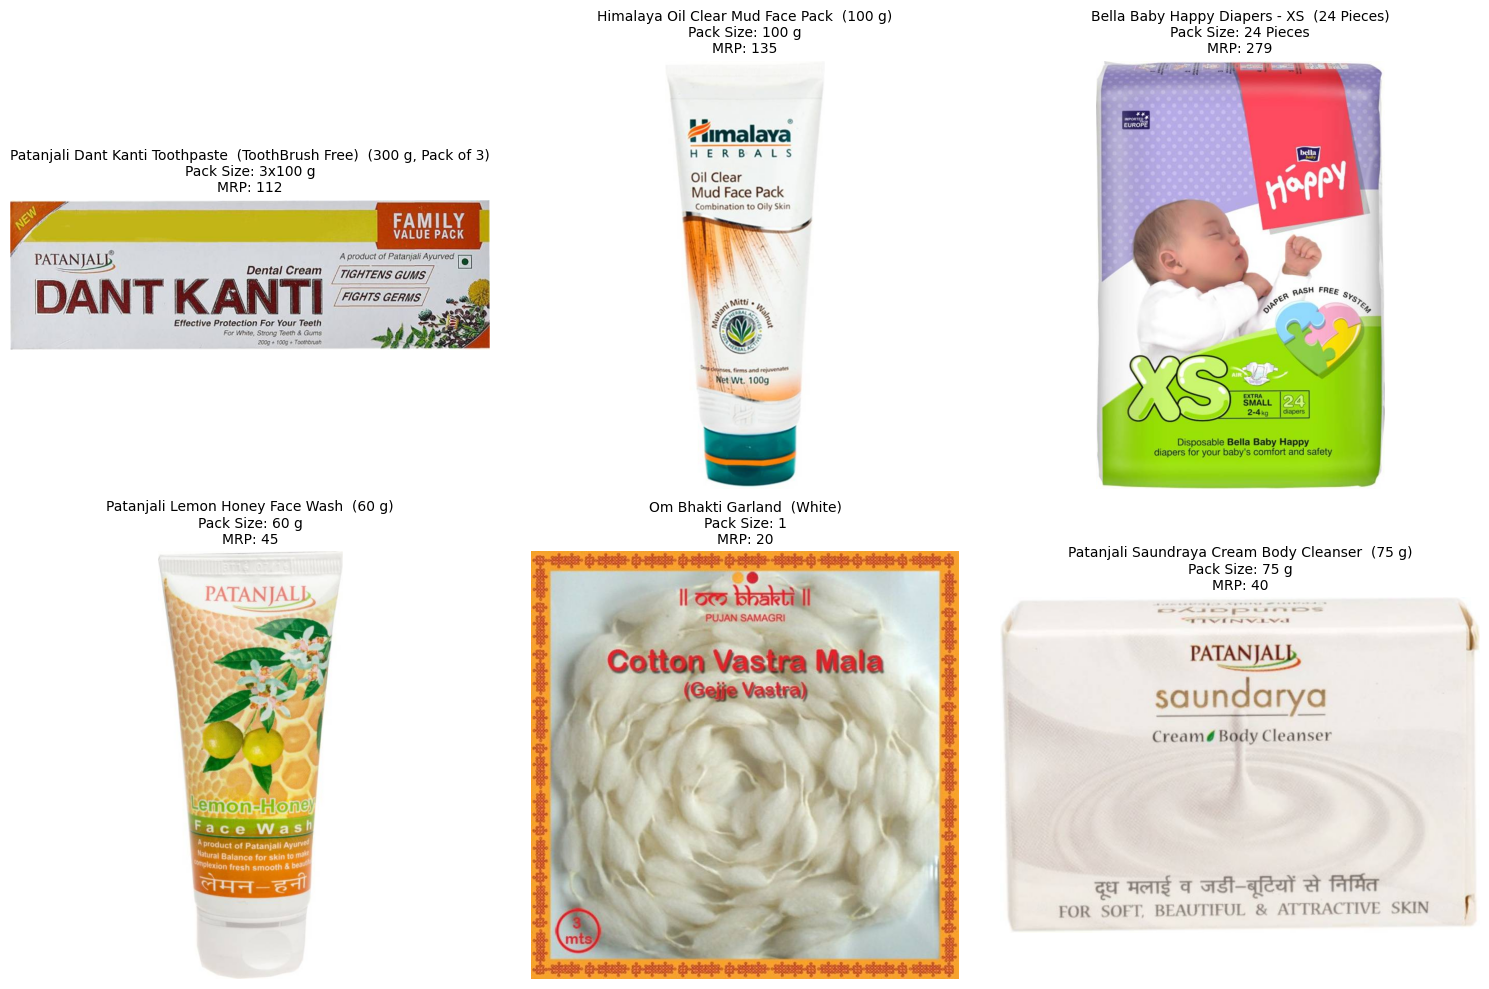

In [26]:
def plot_product_samples(df, sample_size=6):
    # Sample 6 random products from the dataframe
    sample_df = df.sample(sample_size)
    
    # Create a 2x3 plot
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Flatten the axes array for easier iteration
    axs = axs.flatten()
    
    for i, (index, row) in enumerate(sample_df.iterrows()):
        # Get the image from the URL
        try:
            response = requests.get(row['Image Url'])
            img = Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Error loading image for {row['Product Title']}: {e}")
            img = Image.new('RGB', (200, 200), color='gray')  # Placeholder for missing images

        # Plot the image
        axs[i].imshow(img)
        axs[i].axis('off')

        # Add product information as a title
        axs[i].set_title(f"{row['Product Title']}\n"
                         f"Pack Size: {row['Quantity Or Pack Size']}\n"
                         f"MRP: {row['Mrp']}", fontsize=10)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

plot_product_samples(data)

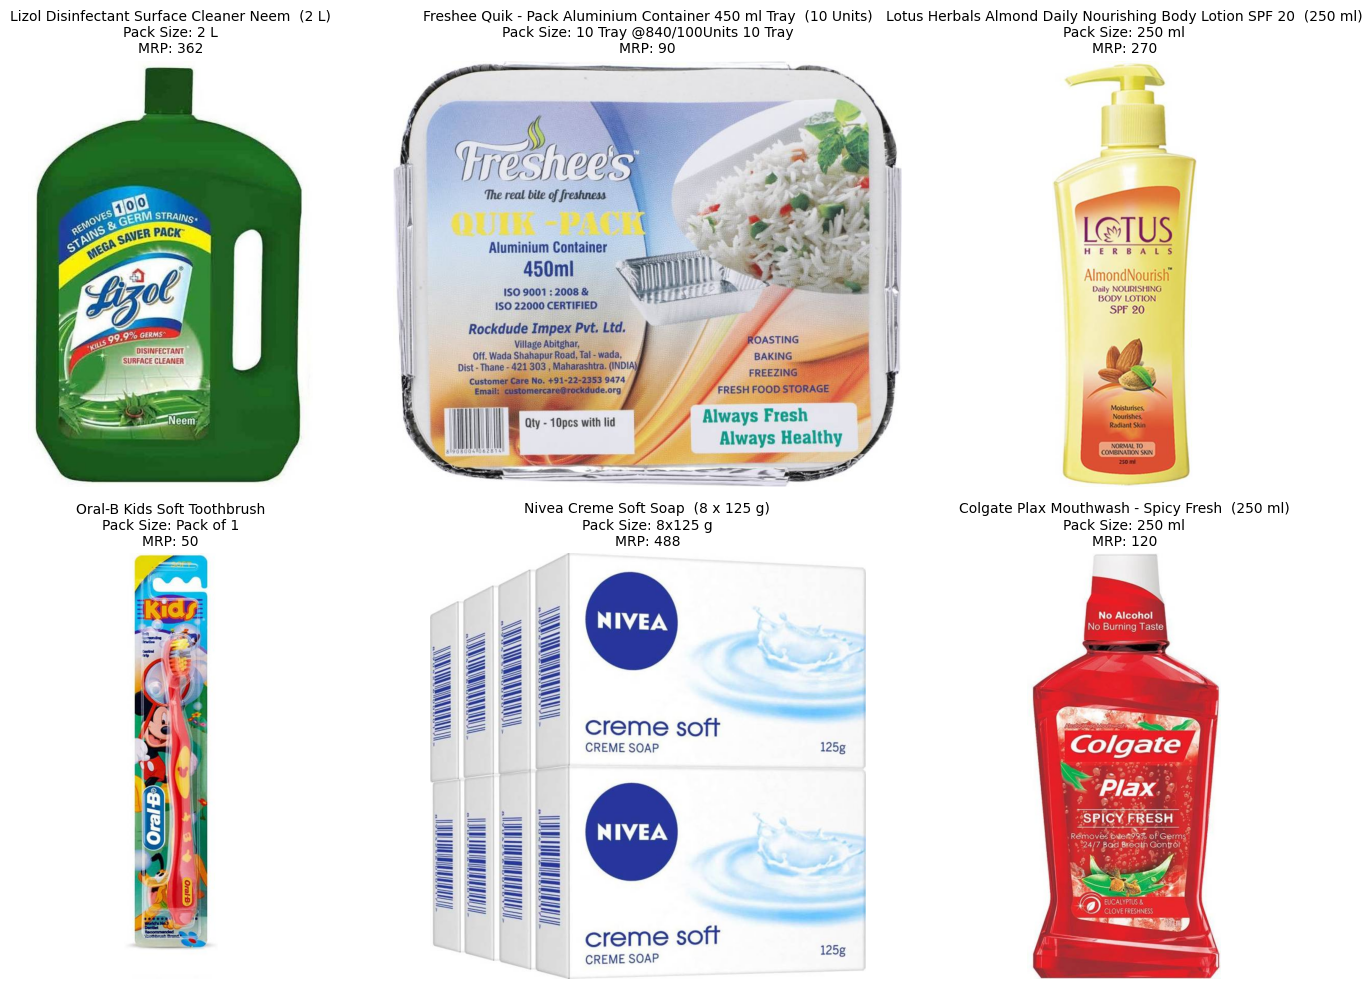

In [27]:
plot_product_samples(data)

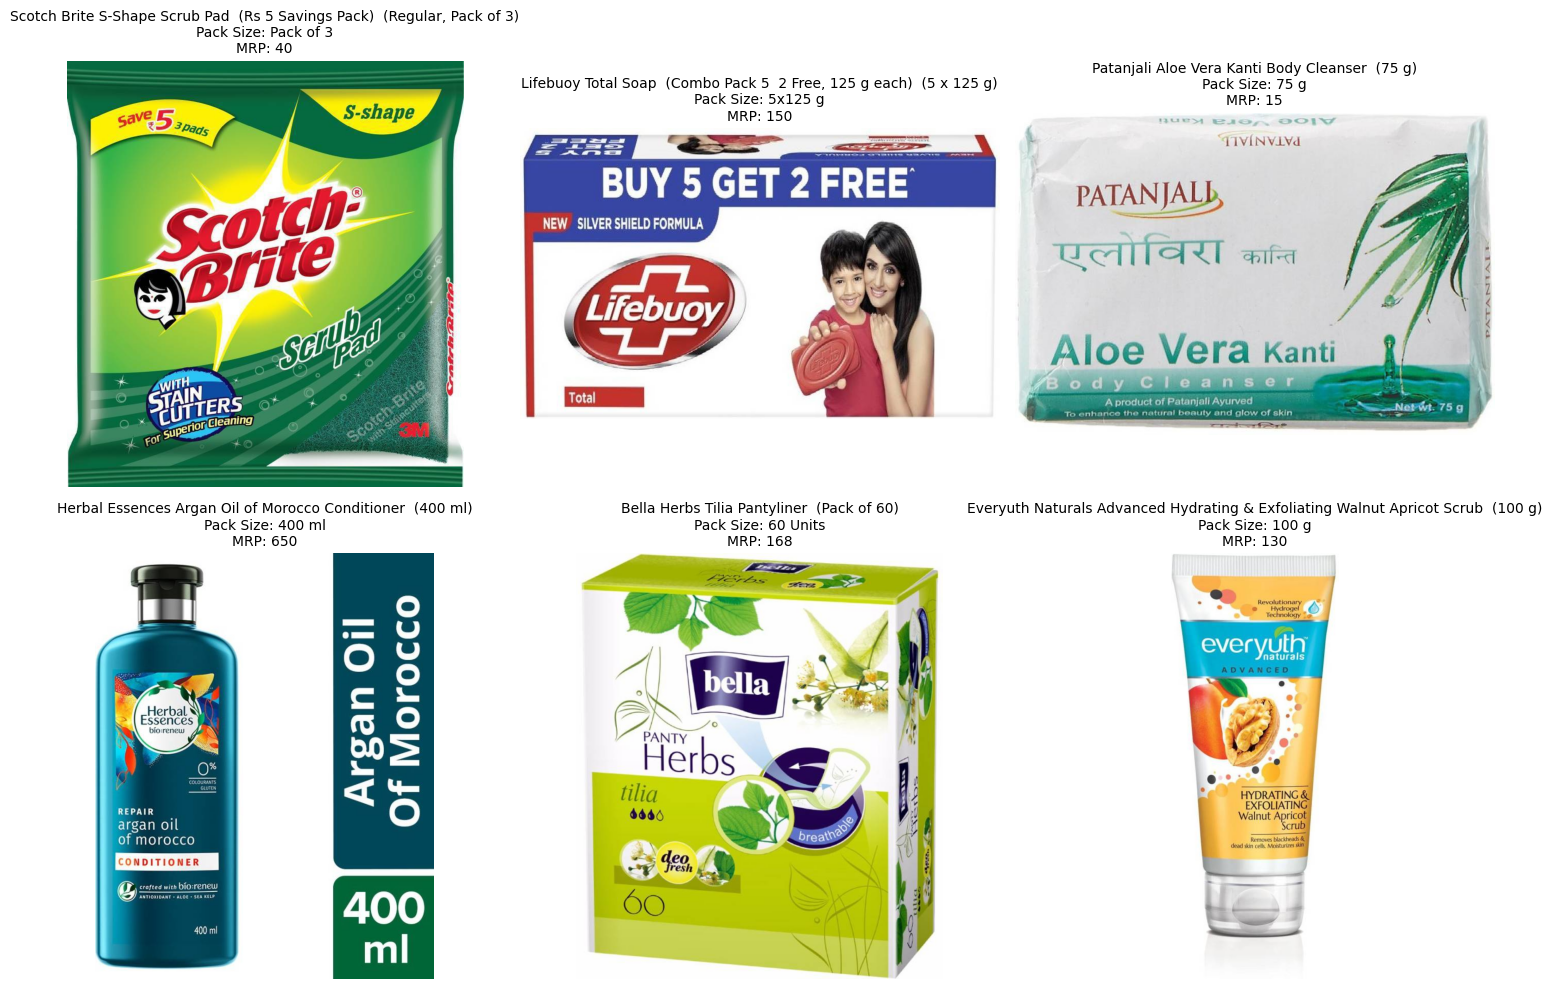

In [28]:
plot_product_samples(data)

In [29]:

def print_random_image_urls(df, n=5):
    # Sample n random rows from the dataframe
    sample_df = df.sample(n)
    
    # Print the Image Url from each sampled row
    for index, row in sample_df.iterrows():
        print(f"Image URL {index + 1}: {row['Image Url']}")
print_random_image_urls(data)

Image URL 12479: http://rukmini1.flixcart.com/image/832/832/sunscreen/z/z/g/lotus-herbals-100-safe-sun-3-in-1-matte-look-daily-sunblock-original-imadgyhvjgczhzcy.jpeg?q=70
Image URL 7981: http://rukmini1.flixcart.com/image/832/832/jplif0w0/body-pain-relief/e/n/y/110-vaporub-vicks-original-imafbsqyzh4ghg9t.jpeg?q=70
Image URL 6658: http://rukmini1.flixcart.com/image/832/832/ja2t8y80/insect-repellent/r/v/t/45-machine-360-hours-refill-1-all-out-original-imaezqkfpvfffuht.jpeg?q=70
Image URL 14827: http://rukmini1.flixcart.com/image/832/832/jsyyufk0/moisturizer-cream/q/y/r/420-soft-moisturing-crme-nourishing-body-milk-lotion-nivea-cream-original-imafeen2wnwdzpxz.jpeg?q=70
Image URL 125: http://rukmini1.flixcart.com/image/832/832/jbl3zbk0/shampoo/3/g/j/340-black-shine-shampoo-dabur-vatika-original-imafyscxmqxj7mfk.jpeg?q=70


In [33]:
data.to_csv("../Data/clean_sdf_2400.csv",index=False )

---